In [1]:
import pandas as pd
import prophet as Prophet
# print version number
print('Prophet %s' % Prophet.__version__)

/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prophet 1.1.1


***
# Given we have the right version - <span style="color:#9400D3">L</span><span style="color:#33FFF9">e</span><span style="color:#0000FF">t</span><span style="color:#00FF00">'</span><span style="color:#FFFF00">s </span><span style="color:#FF7F00">G</span><span style="color:#FF0000">O</span><span style="color:#9400D3">O</span>!
![okaaay - let's go!](https://media.tenor.com/kA9FRdP2JU4AAAAd/okay-lets.gif)
##### *as u can notice it's 2:45 in the morning and it seems that i'm going crazy - but hey at least it's fun*
***

In [58]:
#importing our df
#reading DF
df = pd.read_csv("../../dsfgp/data/cleaned data/total_df.csv").drop(columns=["Unnamed: 0"])
df["DATE"] = pd.to_datetime(df["DATE"])

#preparing df for prophet to work with
kol = df.columns.to_list()
add_regs_list=[]
for i in range(230):
    add_regs_list.append("add"+str(i+1))
add_regs_list
rename_df = dict(zip(kol,add_regs_list))
rename_df['DATE'] = "ds"
rename_df['Herkunftsland - Total'] = "y"

#renaming DF with new column names:
df.rename(columns={"DATE":"ds","Herkunftsland - Total":"y"},inplace=True)

#finally dropping all the country visitors
listen = ['Argentina',
 'Australien',
 'Austria',
 'Bahrain',
 'Belarus',
 'Belgium',
 'Brasil',
 'Bulgaria',
 'Canada',
 'China',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hongkong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kuwait',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'Malta',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Oman',
 'Philippinen',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States']

df.drop(columns=listen,inplace=True)

In [47]:
#fitting DF into Porphet
m = Prophet.Prophet(yearly_seasonality=True)
m.fit(df)

01:06:39 - cmdstanpy - INFO - Chain [1] start processing
01:06:40 - cmdstanpy - INFO - Chain [1] done processing


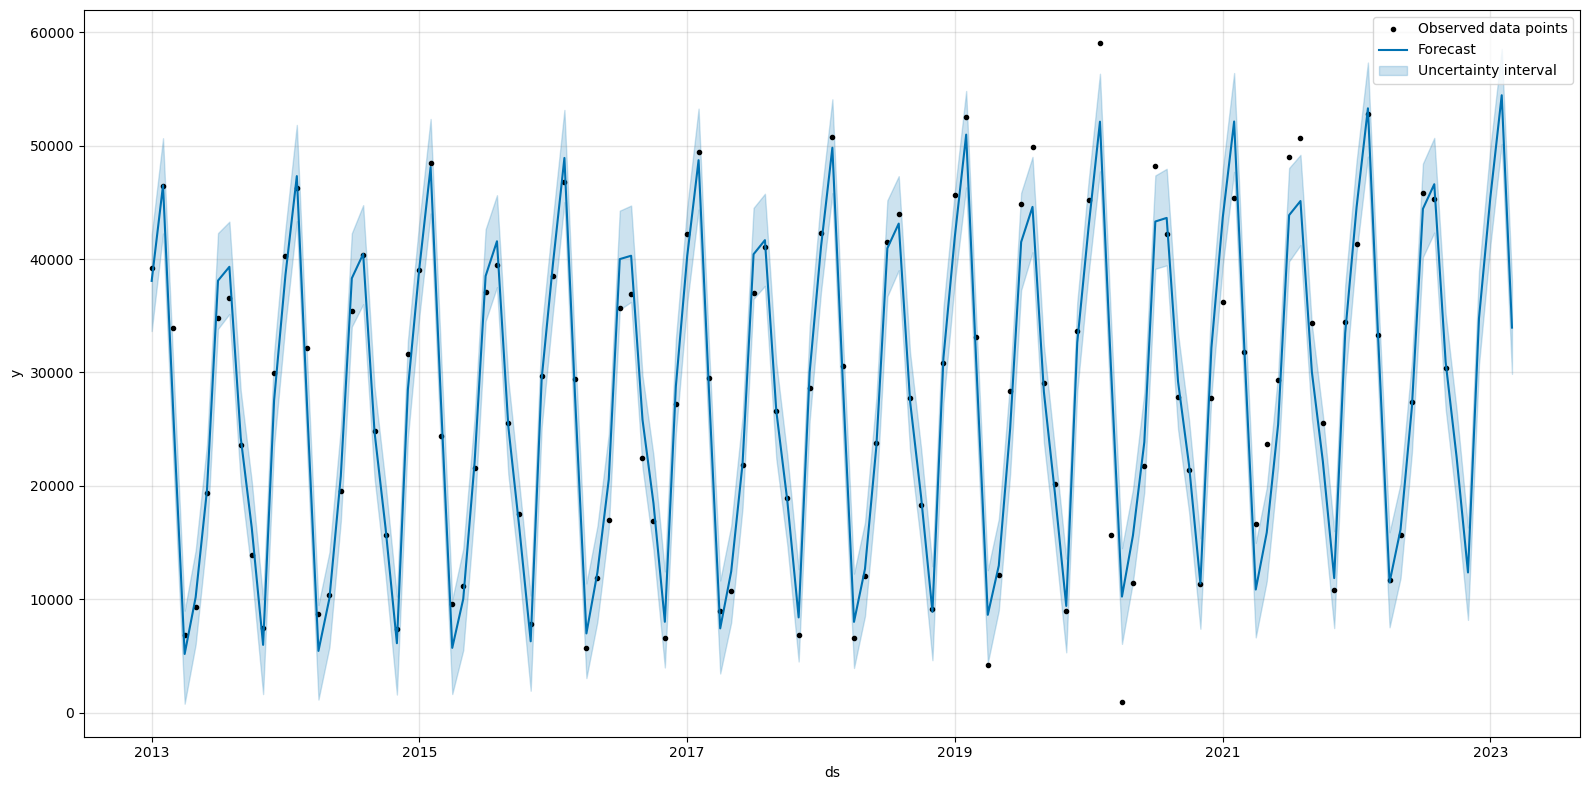

In [48]:
#making a new DF for our prediction for the future
future = m.make_future_dataframe(periods=6, freq="MS")

#getting prophet to forecast future guest numbers into the new future-df based on the data in our original df
fcst = m.predict(future)

#checking forecast
fig = m.plot(fcst, figsize=(16,8), include_legend=True)

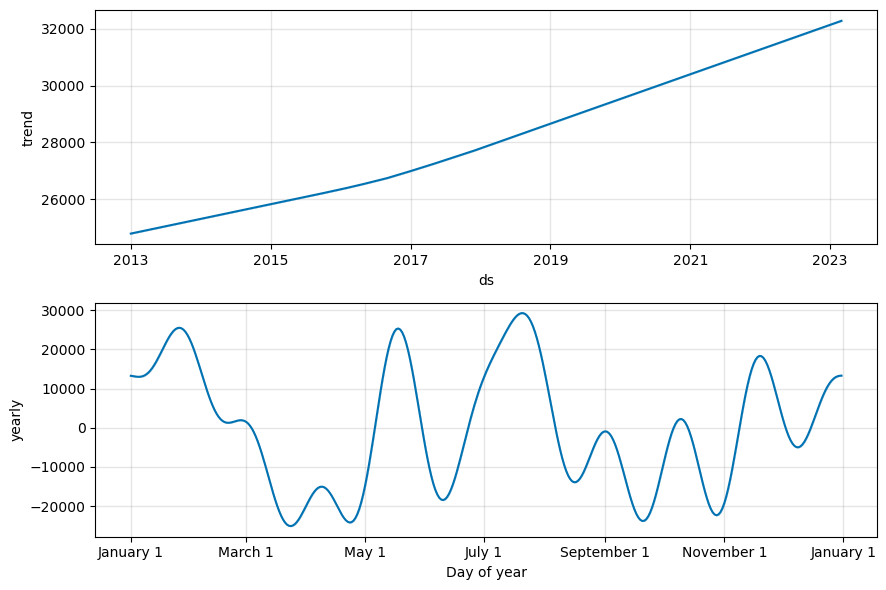

In [5]:
#we can also check the components to better understand what our plot is made of and how we worked the dateframe
fig = m.plot_components(fcst)

In [10]:
#really cool interactive graphs!! I suggest trying it out!
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, fcst)

In [11]:
#another one - lets gooooo
plot_components_plotly(m, fcst)

In [82]:
#now im trying to also fit some exogenous variables (speak add2,add3,add4...add229) and be a bit more precise so lets check the corr first:
df.corrwith(df["y"]).nsmallest(6)
df.corrwith(df["y"]).nlargest(9)
#as we can see we have some very high correlations like st.moritz visitors but also low ones like rainy days with not that much downfall

0      21
1      47
2      29
3       2
4       0
       ..
112     0
113     0
114     0
115     0
116     0
Name: cm avg. snowheight - chd, Length: 117, dtype: int64

In [83]:
#thus we are going to add our top 5 correlated regressors now that are not other communes
m2 = Prophet.Prophet(yearly_seasonality=True)
m2.add_regressor("cm avg. snowheight - chd", standardize=False)
m2.add_regressor('cm avg. snowheight - gsg', standardize=False)
m2.add_regressor('cm neuschnee - chd', standardize=False)
m2.add_regressor('eistage - chd', standardize=False)
m2.add_regressor('frosttage - chd', standardize=False)
m2.fit(df)

01:46:30 - cmdstanpy - INFO - Chain [1] start processing
01:46:30 - cmdstanpy - INFO - Chain [1] done processing


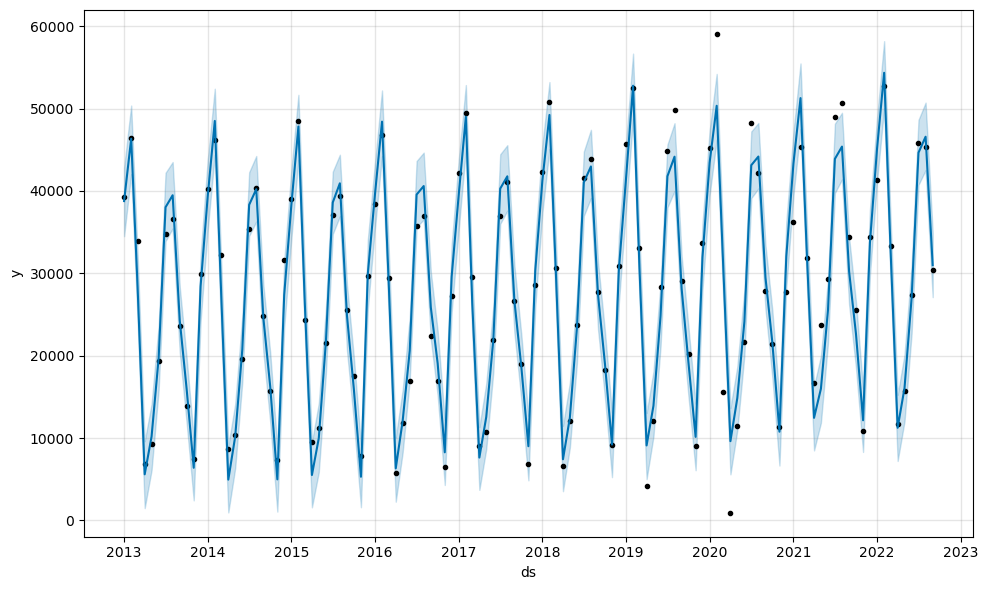

In [90]:
#make new DF with "future" values so we can predict
future_df = m2.make_future_dataframe(periods=6)
#add our 5 regressors to new df
future_df = pd.merge(future_df, df[['ds', "cm avg. snowheight - chd",'cm avg. snowheight - gsg','cm neuschnee - chd','eistage - chd','frosttage - chd']], on='ds', how='inner')

#and now lets forecast a bit ;)
forecast_exog = m2.predict(future_df)
m2.plot(forecast_exog); #semicolon so we do not have double plots

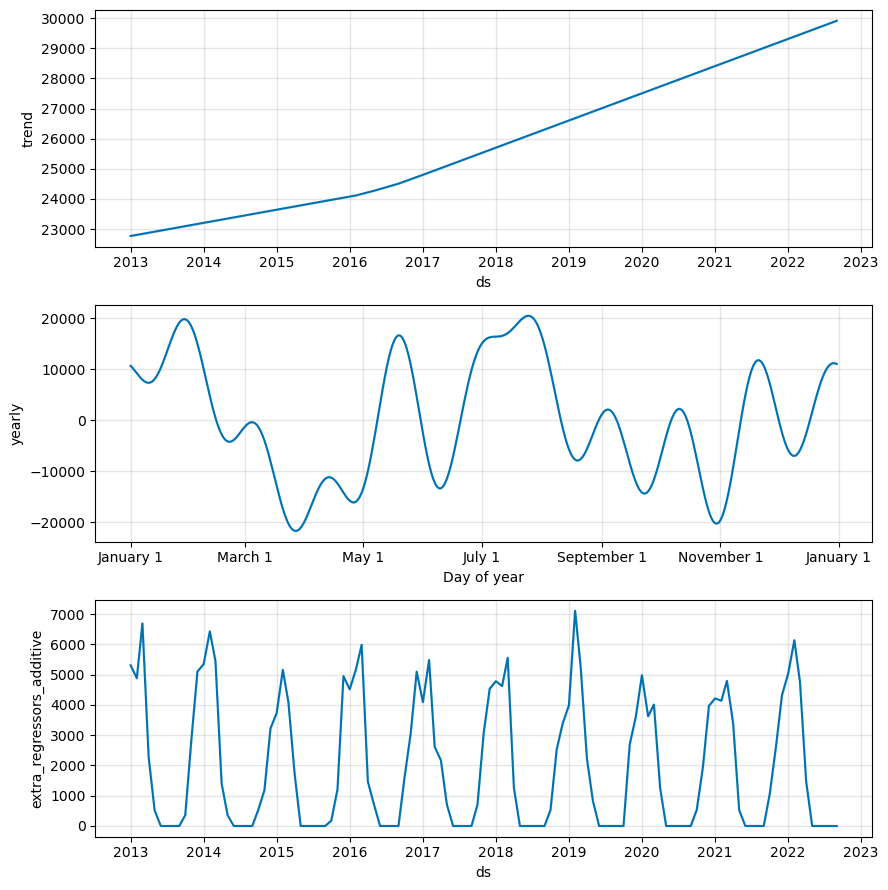

In [91]:
# Visualize the forecast components
m2.plot_components(forecast_exog);

In [ ]:
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

In [94]:
#let's also implement CV so we can be sure to have reliable data
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m2, horizon = '6 m')

  0%|          | 0/104 [00:00<?, ?it/s]01:54:14 - cmdstanpy - INFO - Chain [1] start processing
01:54:18 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/104 [00:05<09:28,  5.52s/it]01:54:19 - cmdstanpy - INFO - Chain [1] start processing
01:54:41 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/104 [00:28<26:52, 15.81s/it]01:54:42 - cmdstanpy - INFO - Chain [1] start processing
01:55:08 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 3/104 [00:54<34:39, 20.59s/it]01:55:08 - cmdstanpy - INFO - Chain [1] start processing
01:55:10 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 4/104 [00:57<22:15, 13.36s/it]01:55:10 - cmdstanpy - INFO - Chain [1] start processing
01:55:12 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 5/104 [00:58<15:05,  9.14s/it]01:55:12 - cmdstanpy - INFO - Chain [1] start processing
01:55:39 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 6/104 [01:26<25:13, 15.44s/it]0